# Point cloud alignment and Lie algebra machinery
[mikoff.github.io](https://mikoff.github.io)

## Special Orthogonal group and vectorspaces

Today I would like to cover the importance of Lie groups to the problems, that often arises in robotics field.
The *pose* of the robot can be described through *rotation* and *translation*. *Rotations*, however, do not belong to the vector space: we are not allowed to sum the rotations or multiply them by a scalar, because the resulting element will not belong to SO(3) group.

Why it stands up a problem? Quite often we need to use the optimization algorithms to find some optimal element. Most of these algorithms start from some initial guess and update it in some direction $y$:
$$
x = x + \epsilon y
$$
This equation does not make any sense if we operate not in the vectorspace!

While SO(3) is not a vector space, it can be shown to be matrix Lie group:
* It is a set of all valid rotation matrices $\{\mathbf{C} \in \mathbb{R}^{3\times3}~|~\mathbf{C}\mathbf{C}^T = \mathbf{1},~\det\mathbf{C} = 1\}$
* satisfying the the four properties: closure, associativity, identity and invertability.

The Lie group theory allows us associate a *Lie algebra* with every Lie group. This Lie algebra consists of a vectorspace, that provides a standard way to parameterize the rotation matrices and their errors.

## Lie Algebra

The vectorspace of a Lie algebra $\mathfrak{so}(3)$ is the tangent space of the associated Lie group, and it completely describes the local structure of the group.

The lie algebra, associated with $SO(3)$ is given by
* vectorspace $\mathfrak{so}(3) = \{\mathbf{\Phi} = \mathbf{\phi}^{\wedge}~\in~\mathbb{R}^{3\times3}~|~\mathbf{\phi} \in \mathbb{R}^3\},$
* field $\mathbb{R}$,
* Lie bracket: $[\mathbf{\Phi}_1, \mathbf{\Phi}_2] = \mathbf{\Phi}_1 \mathbf{\Phi}_2 - \mathbf{\Phi}_2, \mathbf{\Phi}_1,$

where
$$
\mathbf{\phi}^{\wedge} = {\begin{bmatrix} \phi_1 \\ \phi_2 \\ \phi_3 \end{bmatrix}}^{\wedge} =
\begin{bmatrix} 0 & -\phi_3 & \phi_2 \\ \phi_3 & 0 & -\phi_1 \\ -\phi_2 & \phi_1 & 0 \end{bmatrix}
$$

The exponential map is the key that helps us to switch from our Lie algebra to the associated Lie group.
This relationship between a vector space $\mathfrak{so}(3)$ and Lie group is what allows us to convert the rotation matrices optimization problems to linear algebra problems and vice versa (the intuition behind is greatly discussed in this [video](https://www.youtube.com/watch?v=mvmuCPvRoWQ)).

To verify that the Lie algebra element structure, let's assume that we are not aware of its form and only know that it is some arbitrary matrix $\mathbf{C} \in \mathbb{R}^{3\times3}$. By the definition of SO(3) it should fullfill the following properties:
* $\exp(\mathbf{C}) \exp(\mathbf{C})^T = \mathbf{1}$
* $\det(\exp(\mathbf{C})) = 1.$

For the first property, it is easy to show through Taylor serios expansion that $\exp(\mathbf{C})^T = \exp(\mathbf{C^T})$ for any matrix. Also we know that $\exp(\mathbf{0}) = \mathbf{1}$. Therefore:
$$
\exp(\mathbf{C}) \exp(\mathbf{C})^T = \mathbf{1}\\
\exp(\mathbf{C} + \mathbf{C}^T) = \exp(\mathbf{0})\\
\mathbf{C} + \mathbf{C}^T = \mathbf{0}\\
\mathbf{C} = - \mathbf{C}^T
$$
We see, that the first property leads us the the neccessitiy for our Lie algebra to be skew-symmetric.

To check the second property let's recall the following identity:
$$
\det(\exp(\mathbf{C})) = \exp(\mathrm{tr}(\mathbf{C}))
$$
It can only happen when the trace of our matrix is equal to 0. Any skew-symmetric matrix fullfills this property.

## Point cloud alignment with known correspondences and without constraints

The implemented approach is greatly discussed [here](http://asrl.utias.utoronto.ca/~tdb/bib/barfoot_ser17.pdf). I will just point out some key ideas:
* Since the optimization is unconstrained, the SVD or eigen decomposition is not required.
* The result is not optimal globally, but locally. However, if there is a unique global minimum, there is no any local minima.

Let's pretend that we have:
* $M$ measurements $\mathbf{y}_j = \mathbf{r}_{v_k}^{p_j v_k}$, where $j = 1\dots M$, of points from the vehicle (expressed in vehicle frame).
* The coordinates of these points in non-moving frame $i$: $\mathbf{p}_j = \mathbf{r}_{i}^{p_j i}$.

Our goal is to align a collection of points, expressed in two reference frames: find the rotation and translation between them.

To solve the problem we require the following:
* $\mathbf{W} = \frac{1}{w} \sum_{j=1}^M w_j (\mathbf{y}_j - \mathbf{y})(\mathbf{p}_j - \mathbf{p})^T,$

  that captures the spread of the points and where $w_j$ is the scalar weight for point pair $j$.
  
* $\mathbf{I} = -\frac{1}{w} \sum_{j=1}^M w_j (\mathbf{p}_j - \mathbf{p})^\wedge (\mathbf{p}_j - \mathbf{p})^\wedge.$
* $\mathbf{b} = [\mathrm{tr}(\mathbf{1}_i^\wedge \mathbf{C}_{op}) \mathbf{W}^T)]_i,$

  where $i$ is the $i$-th column of the identity matrix and the corresponding $i$-th row of column vector $\mathbf{b}$.
  
The update for our goal rotation matrix $\mathbf{C}_{op}$ can be written as:
$$
\mathbf{C}_{op} \leftarrow \exp \left(\mathbf{\psi}^{{*}^\wedge}\right)\mathbf{C}_{op},
$$
where the optimal update for $\mathbf{\psi}^{*}$ is defined as:
$$
\mathbf{\psi}^{*} = \mathbf{C}_{op} \mathbf{I}^{-1} \mathbf{C}_{op}^T \mathbf{b}.
$$

The following sequence is itereated until convergence, where $\hat{\mathbf{C}}_{v_k i} = \mathbf{C}_{op}$. Then the translation can be found as:
$\hat{\mathbf{r}}_i^{v_k i} = \mathbf{p} - \hat{\mathbf{C}}_{v_k i} \mathbf{y}$.

Now let's move the example:

In [1]:
import numpy as np
from scipy.linalg import fractional_matrix_power
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

def skew(x): 
      if (isinstance(x, np.ndarray) and len(x.shape)>=2): 
          return np.array([[0, -x[2][0], x[1][0]], 
                           [x[2][0], 0, -x[0][0]], 
                           [-x[1][0], x[0][0], 0]]) 
      else: 
          return np.array([[0, -x[2], x[1]], 
                           [x[2], 0, -x[0]], 
                           [-x[1], x[0], 0]])
    
def skewExponent(psi):
    psiNorm = np.linalg.norm(psi)
    a = np.array(psi) / psiNorm
    return np.cos(psiNorm) * np.eye(3) + (1 - np.cos(psiNorm)) * a @ a.T + np.sin(psiNorm) * skew(a)

In [2]:
# define point set P: the point coordinates in non-moving frame
P = np.array(
      [[ 3.,  0.,  0., -3., -0., -0.],
       [ 0.,  2.,  0., -0., -2., -0.],
       [ 0.,  0.,  1., -0., -0., -1.]])\
    + np.array([[100], [200], [300]])

# define point set Y: the point coordinates in vehicle frame
Y = np.array(
      [[-3., -0., -0.,  3.,  0.,  0.],
       [-0., -2., -0.,  0.,  2.,  0.],
       [-0., -0., -1.,  0.,  0.,  1.]])

# calculate the centers of the point clouds
meanP = np.mean(P, axis=1).reshape((3, 1))
meanY = np.mean(Y, axis=1).reshape((3, 1))

# pre-calcaulate W matrix
W = np.zeros((3, 3))
for j in range(P.shape[1]):
    W += (Y[:, [j]] - meanY) @ (P[:, [j]] - meanP).T
    
# pre-calculate I^-1 matrix
I = np.zeros((3, 3))
for j in range(P.shape[1]):
    I -= skew(P[:, [j]] - meanP) @ skew(P[:, [j]] - meanP)
    
invI = np.linalg.inv(I)

# build initial estimate of our rotation matrix
C_op = skewExponent([0.2, 0.1, -0.2]) @ np.eye(3)
C_op = fractional_matrix_power(C_op @ C_op.T, -0.5) @ C_op

C_op_prev = np.eye(3)
I3 = np.eye(3)
while np.linalg.norm(C_op - C_op_prev) > 0.001:
    # build b vector
    b = np.zeros(3)
    for i in range(3):
        b[i] = np.trace(skew(I3[i]) @ C_op @ W.T)
    b = b.reshape((3, 1))

    psi_star = C_op @ invI @ C_op.T @ b

    C_op_prev = C_op
    C_op = skewExponent(psi_star) @ C_op
    
# find the translation
t = meanP - C_op.T @ meanY

print(C_op)
print(t)

[[-1.  0. -0.]
 [-0. -1.  0.]
 [-0.  0.  1.]]
[[100.]
 [200.]
 [300.]]


## Point cloud alignment without correspondences and constraints
If we the correspondences between points are not known, then we can use, for example, the Iterative Closest Point algorithm where the correspondences are determined by finding the closest point from the model to the observed point.
I would like to present a piece of code for this scenario too.

In [3]:
def nearest_point(P, Y):
    P = np.array(P)
    Y = np.array(Y)
    distances = np.zeros(P.shape[1])
    index = np.zeros(Y.shape[1], dtype = np.int)

    for i in range(P.shape[1]):
        minDist = np.inf
        for j in range(Y.shape[1]):
            curDist = np.linalg.norm(P[:, i] - Y[:, j])
            if curDist < minDist:
                minDist = curDist
                index[i] = j
        distances[i] = minDist
    return distances, index

In this simplest ICP form we assume that the number of points is the same and we use all of them for fitting. It is always a good thing to remember that it is not always the case, to solve the problem with outliers and large number of points the following things could be added to the algorithm implementation:
* Randomly select the subset from each point set.
* Split the aligned points to inliers and outliers based on some statistic criteria.
* Throw away the outliers from cloud alignment procedure.

However, for our illustration purposes this vanilla ICP algorithm should work fine. Let's verify it.

In [4]:
# read the rabbit data and make it column-wise
P = np.loadtxt("data.xyz").T * 200

# generate random rotation and translation
C = skewExponent([0.8, 0.6, -0.4]) @ np.eye(3)
C = fractional_matrix_power(C @ C.T, -0.5) @ C
translation = np.array([[10], [20], [30]])

# rotate and translate original points, add noise
Y = C @ (P - translation) + np.random.normal(0.0, 0.1, size=P.shape)
# randomly shuffle the columns to find the correspondences using ICP
np.random.shuffle(Y.T)
Y_original = np.array(Y)

# build initial estimate of our rotation matrix
C_op = np.eye(3)
C_op_prev = np.diag([np.inf, np.inf, np.inf])
I3 = np.eye(3)
distances = np.inf

MAX_ITER = 20
iteration = 0

while (np.linalg.norm(C_op - C_op_prev) > 0.001 or np.sum(distances) > 1.0) and iteration < MAX_ITER:
    # calculate the centers of the point clouds
    meanP = np.mean(P, axis=1).reshape((3, 1))
    meanY = np.mean(Y, axis=1).reshape((3, 1))
    
    # calculate W matrix
    W = np.zeros((3, 3))
    W = (Y - meanY) @ (P - meanP).T
      
    # build b vector
    b = np.zeros(3)
    for i in range(3):
        b[i] = np.trace(skew(I3[i]) @ C_op @ W.T)
    b = b.reshape((3, 1))

    # calculate I matrix
    I = np.zeros((3, 3))
    for p in P.T:
        skewP = skew(p - meanP.ravel())
        I -= skewP @ skewP
    psi_star = C_op @ np.linalg.inv(I) @ C_op.T @ b

    C_op_prev = C_op
    C_op = skewExponent(psi_star) @ C_op
    t = meanP - C_op.T @ meanY
    
    # find correspondences using ICP
    distances, index = nearest_point(P, t + C_op.T @ Y_original)
    # replace the point set with correspondences
    Y = Y_original[:, index]
    
    iteration += 1
    
print(C_op)
print(t)

[[ 0.866  0.16   0.474]
 [ 0.162  0.807 -0.568]
 [-0.474  0.569  0.672]]
[[10.012]
 [19.977]
 [29.995]]


If we are talking about the vehicle positioning, then we have found the rotation matrix $\hat{\mathbf{C}}_{v_k i}$ and the translation $\hat{\mathbf{r}}_i^{v_k i}$.
Now we can apply the found rotation and translation to the transformed dataset to visually check the algorithm performance.

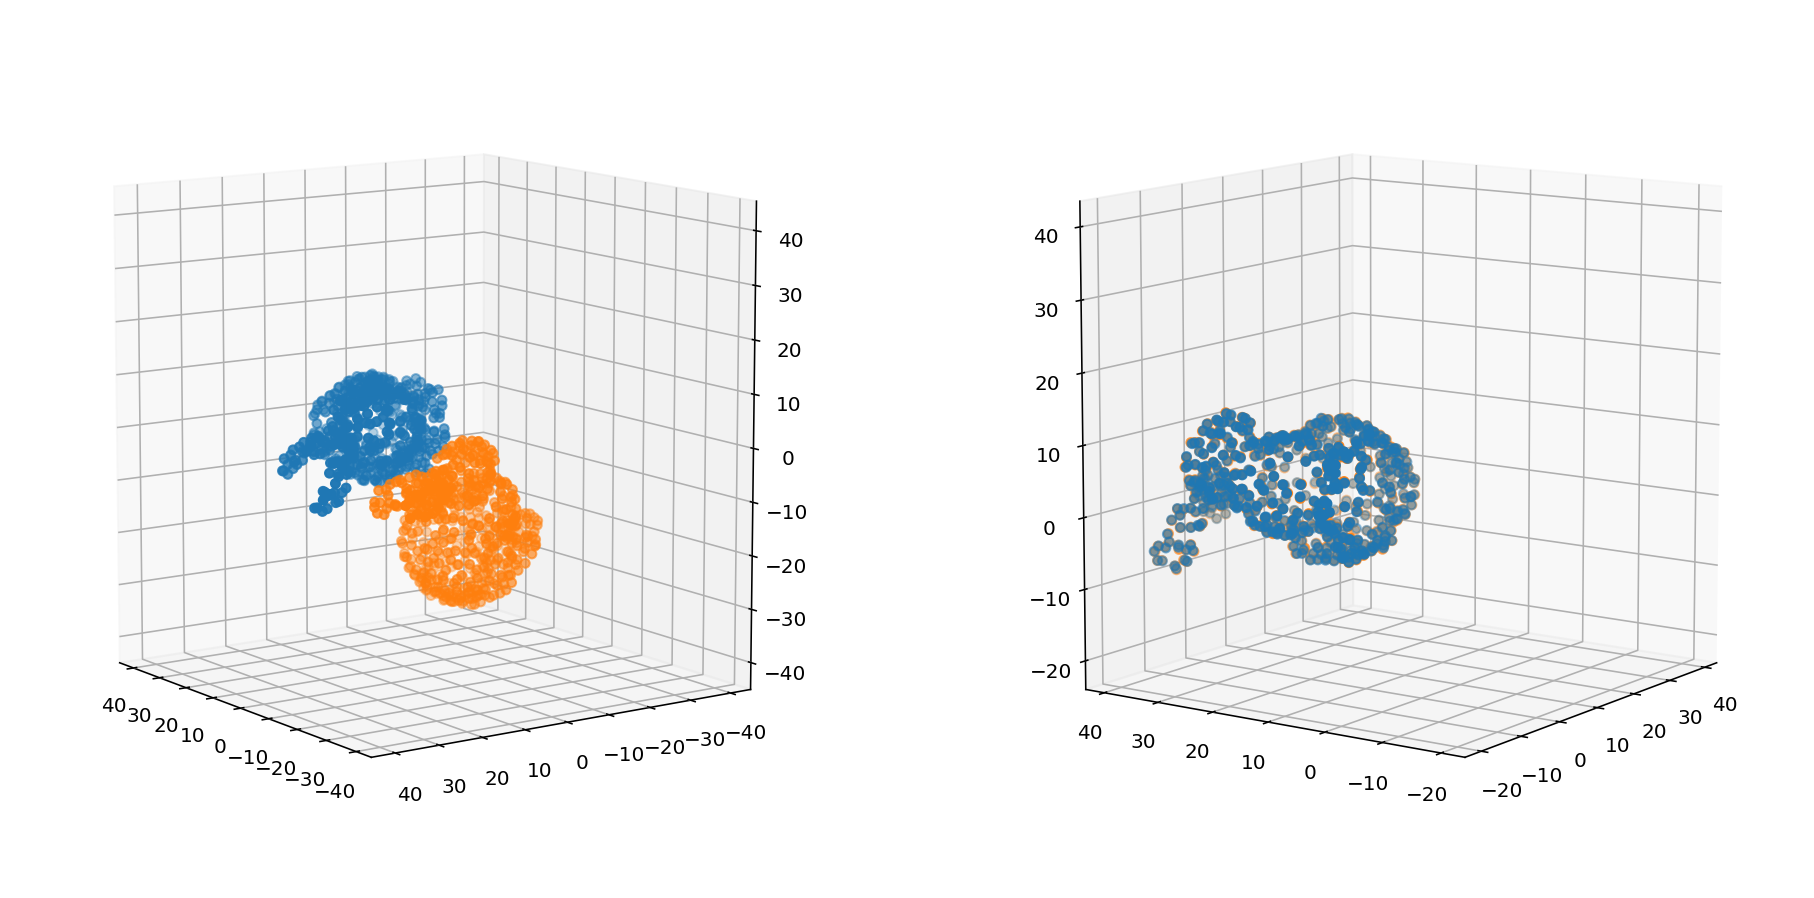

In [5]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

fig, ax = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(16, 8))
ax[0].scatter(P[0,:], P[1,:], P[2, :], ',')
ax[0].scatter(Y_original[0,:], Y_original[1,:], Y_original[2, :], 'X')
scaling = np.array([getattr(ax[0], 'get_{}lim'.format(dim))() for dim in 'xyz'])
ax[0].auto_scale_xyz(*[[np.min(scaling), np.max(scaling)]]*3)

ax[1].scatter(P[0,:], P[1,:], P[2, :], ',')
Y = C_op.T @ Y_original + t
ax[1].scatter(Y[0,:], Y[1,:], Y[2, :], 'X')
scaling = np.array([getattr(ax[1], 'get_{}lim'.format(dim))() for dim in 'xyz'])
ax[1].auto_scale_xyz(*[[np.min(scaling), np.max(scaling)]]*3)

ax[0].view_init(elev=10., azim=-215)
ax[1].view_init(elev=10., azim=215)

They are quite close!
Jupyter notebook is available [here](https://github.com/mikoff/blog_projects/tree/master/notebooks/Point_cloud_alignment_and_Lie_algebra_machinery).